In [6]:


import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.ndimage import label
from shapely.geometry.polygon import Polygon

from src.gaussian_noise import BetaSchedule, ModelMeanType, ModelVarType
from src.respace import SpacedDiffusion, space_timesteps
from src.rplan.dataset import RPlanImageDataset
from src.rplan.types import ImagePlan, RoomType, Plan
from src.rplan_masks.karras.cfg import CFGUnet, CFGUnetWithScale
from src.utils.sampler import Sampler


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dataset = RPlanImageDataset(data_path='../data/rplan', mask_size=(64, 64), shuffle_rooms=True,
                                random_scale=0.6)
random_sample = dataset[np.random.randint(0, len(dataset))]
random_sample_batched = ImagePlan.collate([random_sample])
images, walls, doors, room_types, bubbles, masks = random_sample_batched

In [15]:
T = 1000

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

diffusion = SpacedDiffusion(space_timesteps(T, 'ddim100'), T, BetaSchedule.COSINE, ModelMeanType.EPSILON, ModelVarType.FIXED_SMALL,
                              device=device)
model = CFGUnet(dim=64, channels=6, out_dim=3, cond_drop_prob=0, use_bubbles=True).to(device)

# model.load_state_dict(torch.load(
#     '/Users/mariodeaconescu/Library/CloudStorage/GoogleDrive-mariodeaconescu2003@gmail.com/My Drive/ColabFiles/diffusion_generation/export/checkpoints/2025-03-07_16-42-58/model_49.pt', map_location=device))
model_path = '/Users/mariodeaconescu/Library/CloudStorage/GoogleDrive-mariodeaconescu2003@gmail.com/My Drive/ColabFiles/diffusion_generation/export/checkpoints_unet_bubbles/2025-04-21_00-54-32/model_29_500.pt'
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
full_model = CFGUnetWithScale(model).to(device)
sampler = Sampler(full_model, (3, 64, 64), diffusion, ddim=True, device=device)

In [55]:
sample = sampler.sample(
        1,
        model_kwargs={
            'room_types': room_types.to(device),
            'bubbles': bubbles.to(device),
            'masks': masks.to(device),
            'condition_scale': 0,
            'rescaled_phi': 0,
        }
    )

100it [00:03, 30.69it/s]


In [56]:
rooms, walls, doors = sample[0].cpu().numpy()

In [57]:
sampled = ImagePlan(walls=walls, image=rooms, door_image=doors)

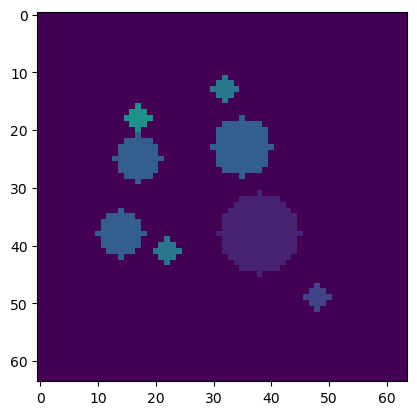

In [58]:
plt.imshow(random_sample.bubbles[0], vmin=-1, vmax=1)

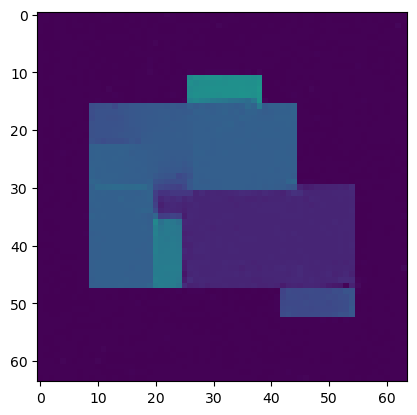

In [59]:
plt.imshow(sampled.image, vmin=-1, vmax=1)

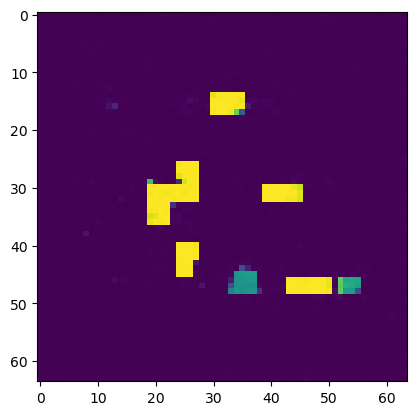

In [61]:
plt.imshow(sampled.door_image, vmin=-1, vmax=1)

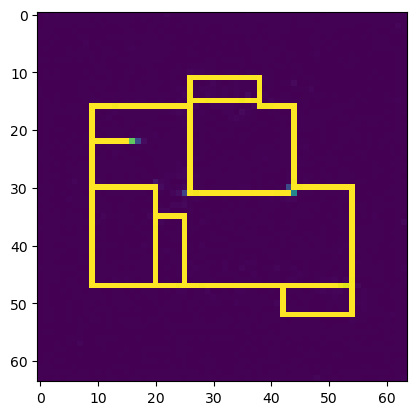

In [62]:
plt.imshow(sampled.walls)

In [107]:
def to_plan(img_plan: ImagePlan):
    walls = img_plan.walls > 0
    enclosing = ~walls
    labeled, num_rooms = label(enclosing)
    # Include walls in labeled
    filter_size = 3
    outside_id = 1
    # for room_id in range(1, num_rooms + 1):
    #     mask = labeled == room_id
    #     average_room_type = img_plan.image[mask].mean()
    #     room_type = ImagePlan.value_to_room_type(average_room_type)
    #     if room_type is None:
    #         outside_id = room_id
    #         break
    # labeled[labeled == outside_id] = 0
    # labeled_extended = labeled.copy()
    # for x in range(labeled.shape[0]):
    #     for y in range(labeled.shape[1]):
    #         if not walls[x, y]:
    #             continue
    #         x_bounds = max(0, x - filter_size), min(labeled.shape[0], x + filter_size)
    #         y_bounds = max(0, y - filter_size), min(labeled.shape[1], y + filter_size)
    #         filter = labeled[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
    #         filter_mode = mode(filter[filter > 0], axis=None)[0]
    #         labeled_extended[x, y] = filter_mode

    plt.imshow(labeled)
    plt.show()
    # plt.imshow(labeled_extended)
    # plt.show()
    #
    # labeled = labeled_extended


    rooms = []
    for room_id in range(1, num_rooms + 1):
        mask = labeled == room_id
        if mask.sum() < 5:
            continue
        average_room_type = img_plan.image[mask].mean()
        room_type = ImagePlan.value_to_room_type(average_room_type)
        if room_type is None:
            continue
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        polygons = [Polygon(contour.squeeze() * 4) for contour in contours if contour.shape[0] > 2]
        polygon = max(polygons, key=lambda polygon: polygon.area)

        polygon = polygon.simplify(tolerance=2.5, preserve_topology=True)
        rooms.append(Plan.Room(room_type=room_type, corners=polygon.exterior.coords))

    return Plan(rooms=rooms)


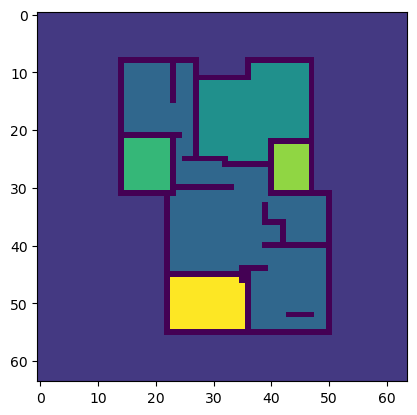

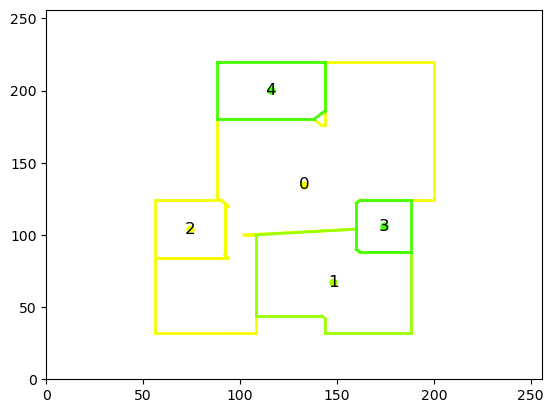

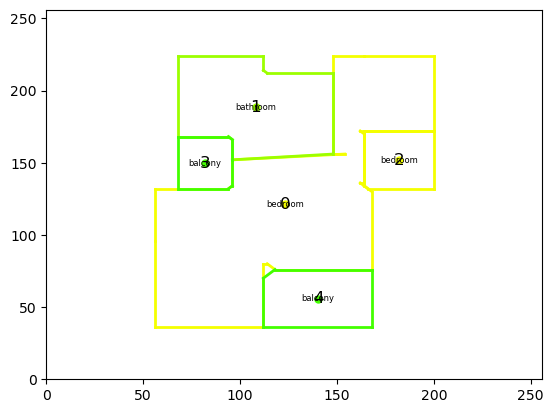

In [61]:
plan = to_plan(sampled)
plan.expand(4)
plan.remove_overlaps()
# plan.rotate_90(2, canvas_size=(256, 256))
plan.visualize()

plan.flip((256, 256), vertical=True, horizontal=True)
# plan.rotate_90(1, canvas_size=(256, 256))

plan.visualize(view_room_type=True)

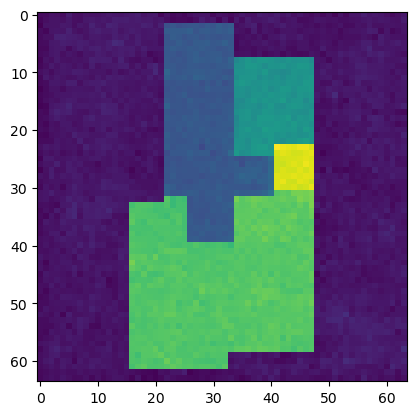

In [45]:
plt.imshow(sampled.image)